# Pilot study: relationship between peak tangential pedal force angle and power/cadence using Wattbike data

## Initialization

In [1]:
from datetime import date

import pandas as pd
from sklearn import linear_model
from wblib.models import WattbikeDataFrame

%matplotlib inline

In [2]:
user_id = 'u-1756bbba7e2a350'
wdf = WattbikeDataFrame()
wdf = wdf.load_for_user(user_id, after=date(2017, 1, 1), before=date(2017, 12, 1))
wdf = wdf.assign(
    mean_peak_angle=wdf[['right_max_angle', 'left_max_angle']].mean(axis=1)
)
wdf_without_polar_plots = wdf[['session_id', 'power', 'cadence', 'mean_peak_angle']].dropna()
wdf_without_polar_plots.to_csv('./data.csv')

/Users/aart/Documents/projects/publications/venv/lib/python3.6/site-packages/wblib/models.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.performance_states = {}


In [3]:
wdf_without_polar_plots = WattbikeDataFrame(pd.read_csv('./data.csv'))

In [4]:
print('Memory usage of all data: {}MB'.format(int(round(wdf.memory_usage().sum()/1000000))))

Memory usage of all data: 520MB


In [5]:
print('Number of sessions: {}'.format(len(set(wdf.session_id))))

Number of sessions: 33


In [6]:
print('Number of pedal revolutions: {}'.format(len(wdf_without_polar_plots)))

Number of pedal revolutions: 164564


## Introduction

The pedaling motion is characterized by a circular movement where the goal is to deliver as much work as possible by maximizing the tangential (i.e. perpendicular to the crank arms) force on the pedals. It is known that the force curve describing this tangential force is not constant throughout a pedal revolution but instead contains dead spots where the crank arms are vertical (see figure 1; most likely because it is difficult for cyclists to apply the horizontal tangential force at those locations). The force curve also contains a maximum during the downward motion of the cranks at which the force is the highest. The angle at which this maximum force occurs is the peak tangential pedal force angle. This article will focus on this angle to gain an understanding on the relationship between power and cadence and this angle.

The tangential forces during 1 revolution can be plotted in 2 ways: With a traditional Cartesian coordinate system (figure 1) or with polar coordinate system (figure 2). The latter gives a nice visual representation of the pedal revolution that makes it slightly easier to compare the timing of the forces during the downward motion of the  left and right leg.

The angles in the Cartesian plot correspond to:
- 0° left crank pointing upward, right crank pointing downward
- 90° left crank horizontal forward, right crank backward
- 180° right crank pointing upward, left crank pointing downward
- 270° right crank horizontal forward, left crank backward
- 360° identical to first 0°; left crank vertical pointing upward

In the polar plot the angles are ‘reset’ when a crank is vertical to be able to compare angles during the downward phases of each crank (i.e. leg), therefore the angles in the polar plot correspond to:
- Top 0° left crank pointing upward, right crank pointing downward
- Left 90° left crank horizontal forward, right crank backward
- Bottom 0°right crank pointing upward, left crank pointing downward
- Right 90° right crank horizontal forward, left crank backward
- Top 0° identical to first 0°; left crank vertical pointing upward

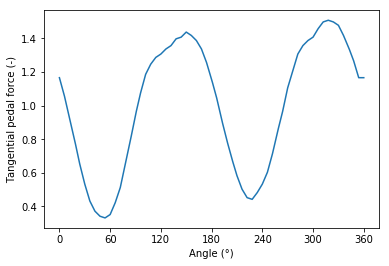

In [7]:
from wblib.tools import polar_force_column_labels
from matplotlib.pyplot import text
single_revolution = wdf.iloc[99999]
forces = pd.Series([single_revolution[angle] for angle in polar_force_column_labels()])
fig_forces_cartesian = forces.plot()
fig_forces_cartesian.set_xlabel('Angle (°)')
fig_forces_cartesian.set_ylabel('Tangential pedal force (-)');
fig_forces_cartesian.set_xticks(range(0, 361, 60));

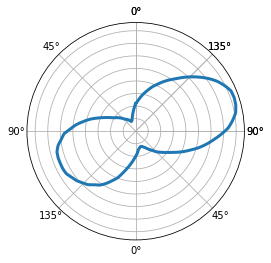

In [8]:
fig_forces_polar = WattbikeDataFrame([wdf.iloc[1337]]).plot.polar()

## Methods and data

The Wattbike indoor bike measures a resultant of the tangential pedal force by measuring the tension on the chain. The chain tension is measured with a constant frequency of 100Hz which results in a different number of datapoints for each pedal revolution depending on the cadence. The excellent (yeah... I wrote it myself) library [wblib](https://github.com/aartgoossens/wblib) interpolates and normalizes these datapoints to 360 datapoints per revolution (1 datapoint per degree) so analyzing the data is quite straightforward.

All Wattbike workouts for 1 athlete (me, the author) between January 1st 2017 and December 1st 2017 are downloaded via a custom script from the Wattbike Hub servers. The total number of workouts is 33, containing a total of 164564 pedal revolutions. The entire dataset 'only' consumes about 520MB of memory, but since writing it to a csv-file on disk would take up about 4.5GB only a subset without the raw polar plot data is available in this repository ('peak_angle/data.csv').

## Results

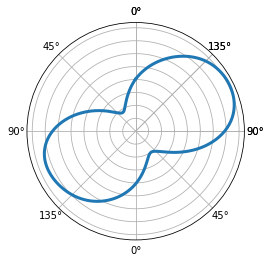

In [9]:
fig_average = wdf.plot.polar()

In [10]:
wdf.mean_peak_angle.mean()

117.0960355849396

The average polar plot for all sessions is shown above in figure 1. One can think of this polar plot as the 'signature' polar plot for this cyclist. The average peak angle is 117 degrees.

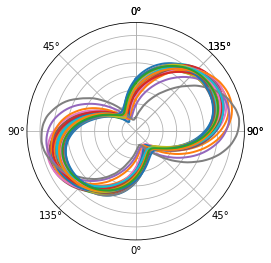

In [11]:
for session_id in set(wdf.session_id):
    fig_sessions = wdf.loc[wdf.session_id == session_id].plot.polar(linewidth=2.0)

If the average polar plot for each workout is plotted separately like in figure 2 above, you can see that allthough the main characteristics of the plots (shape, peak angle, 'height' of dead spot) are similar, there is some variation between workouts. The brown-ish and blue polar plots are most distinguishable from the rest and happen to correspond to the two shortest workouts (containing only 21 and 215 revolutions each) where the cyclist probably only recorded part of a warming-up.

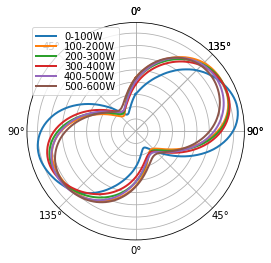

In [12]:
min_power = 0
max_power = 100
while max_power <= 600:
    fig_power = wdf.loc[wdf.power.between(min_power, max_power)].plot.polar(linewidth=2)
    min_power += 100
    max_power += 100
fig_power.legend(['{}-{}W'.format(i, i+100) for i in range(0, 600, 100)], labelspacing=0);

When we look at the polar plot for different power ranges a similar result is shown (figure 3). Allthough there is some variation between power ranges, the overall characteristics are very similar, with the exception of the range 0-100W. At first sight there does not seem to be an obvious relationship between power and peak angle.

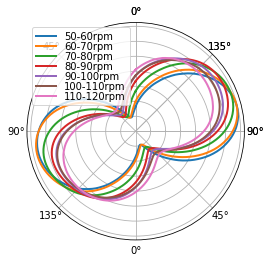

In [13]:
min_cadence = 50
max_cadence = 60
while max_cadence <= 120:
    fig_cadence = wdf.loc[wdf.cadence.between(min_cadence, max_cadence)].plot.polar(linewidth=2)
    min_cadence += 10
    max_cadence += 10
fig_cadence.legend(['{}-{}rpm'.format(i, i+10) for i in range(50, 120, 10)], labelspacing=0);

When the same plot is made for cadence (figure 3) it looks like there is more variation and also a positive relationship between peak angle and cadence: higher cadence appears to correlate to higher peak angles. The overall shape of the polar plots stays very similar between cadence ranges although the dead spots are less 'dead' at higher cadences. One thing to note here is that the polar plots for higher cadences are smaller. This is most probably a result of the fact that the forces of which each polar plot consist are normalized to their mean, therefore 'smooth' force curve will result in a smaller polar plot than for a force curve where the peak force is more pronounced.

To calculate the model describing these data a linear mixed model is used. This type of model can be used to calculate linear regression in the form of y=a*x + b (but also for multiple independent variables) where the samples are grouped into subsets. The model parameters are shown in the table below.

In [14]:
import statsmodels.api as sm

X = wdf_without_polar_plots[['power', 'cadence']]
X = sm.add_constant(X)
y = wdf_without_polar_plots['mean_peak_angle']
groups = wdf_without_polar_plots['session_id']

model = sm.MixedLM(y, X, groups).fit()
predictions = model.predict(X)

model.summary()

/Users/aart/Documents/projects/publications/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: mean_peak_angle
No. Observations: 164564  Method:             REML           
No. Groups:       33      Scale:              157.0849       
Min. group size:  19      Likelihood:         -649690.7851   
Max. group size:  7349    Converged:          Yes            
Mean group size:  4986.8                                     
--------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
const         68.295     0.657  103.934  0.000  67.007  69.583
power         -0.025     0.000  -78.457  0.000  -0.025  -0.024
cadence        0.630     0.003  202.328  0.000   0.624   0.636
Group RE      12.222     0.255                                
=============================================================

"""

In [16]:
print('mean_peak_angle = power*{power_coef} + cadence*{cadence_coef} + {constant}'.format(
    power_coef=model.params.power.round(3),
    cadence_coef=model.params.cadence.round(3),
    constant=int(model.params.const.round(0))
))

mean_peak_angle = power*-0.025 + cadence*0.63 + 68


The resulting formula for the model is:

mean_peak_angle = power\*-0.025 + cadence\*0.63 + 68.295

The results of the analysis make it clear that both power and cadence have a signficant relationship with the peak force angle: For both independent variables the p value is <0.05 (even <0.001). With a large number of samples like this (n=164564) a significant relationship between variables is highly likely so in this case it is more interesting to look at effect sizes, the coefficients. For the independent variable power this coefficient is quite small: For every 1 Watt increase in power the peak force angle decreases by 0.025 degree. For cadence this coefficient is larger: For every 1 rpm increase in cadence the peak force angle increases by 0.63 degree. This data suggests that although power has a significant relationship with peak force angle, a larger amount of the variation in peak force angle is explained by changes in cadence.

## Conclusion

Although it might sometimes appear as if high power results in high peak angles, the opposite is true: The model parameters show that high peak angles correspond to high cadence and that power even has an inverse relationship with peak angle. There are however a few points to keep in mind when interpreting these results:
- Although the coefficient for power in the model is smaller than the coefficient for cadence, during a typical cycling workout the variation in power can be much larger than the variation in cadence: Whereas the power can change from e.g. 100W to 500W (resulting in a decrease in peak angle of 10°), the cadence can only change from e.g. 70rpm to 110rpm (resulting in an increase in peak of 25°). If you look at the data like this the effect of power is still smaller than the effect of cadence but not as small as you would expect when only looking at the coefficients of the model.
- A confounding factor in the data is that it contains pedal revolutions in both sitting and standing positions. Standing positions seem to increase the peak force angle by a lot (I will publish an article on this topic later) which might add noise to the data. On the other hand, the percentage of standing pedal revolutions is estimated at <0-5% so the effect could be small.
- The dataset contains only data from 1 cyclist. The relationship between power, cadence and peak angles might be existent for this cyclist but not for another. I am working on gathering more data to do the same analysis for more cyclists. Get in touch with me if you are willing to donate your data. :)

## Exporting images

In [18]:
import numpy as np
figures = [fig_forces_cartesian, fig_forces_polar, fig_average, fig_sessions, fig_power, fig_cadence]
figure_names = ['fig_forces_cartesian', 'fig_forces_polar', 'fig_average', 'fig_sessions', 'fig_power', 'fig_cadence']
for fig, name in zip(figures, figure_names):
    if hasattr(fig, 'savefig'):
        f = fig
    elif isinstance(fig, np.ndarray):
        f = fig[0].get_figure()
    else:
        f = fig.get_figure()

    f.savefig(f'{name}.png', dpi=600)